In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans, DBSCAN, MeanShift, HDBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import defaultdict
from tqdm import tqdm
from scipy.linalg import inv

PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [3]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='full_window', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
                    #   mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
da.load_results()

Initializing T1024 ...
casp_da/T1024_win4-5-6-7
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


In [ ]:
#T1024: --------HHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHEE-----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--HHHHHHHHHHHHHHHHHHHHH-----------------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-------EEEE--HHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--
#T1030: -HHHHHHHHHHHHHHH-------HHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHH----------EEHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH------HHHHHHHHHHHHHHHHHHH---------HHHHHHHHH-----------EE----HHHHHHHHHHHHHHHHHHHHHH------

In [4]:
ss = '--------HHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHEE-----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--HHHHHHHHHHHHHHHHHHHHH-----------------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-------EEEE--HHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--'

In [28]:
da.sequence[da.winsize_ctxt//2:len(da.sequence) - da.winsize_ctxt // 2]

'FWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAVATFVAGILAGFFADRNGRKPVMVFGTIIQLLGAALAIASNLPGHVNPWSTFIAFLLISFGYNFVITAGNAMIIDASNAENRKVVFMLDYWAQNLSVILGAALGAWLFRPAFEALLVILLLTVLVSFFLTTFVMTETFKPTVKVDNIFQAYKTVLQDKTYMIFMGANIATTFIIMQFDNFLPVHLSNSFKTITFWGFEIYGQRMLTIYLILACVLVVLLMTTLNRLTKDWSHQKGFIWGSLFMAIGMIFSFLTTTFTPIFIAGIVYTLGEIVYTPSVQTLGADLMNPEKIGSYNGVAAIKMPIASILAGLLVSISPMIKAIGVSLVLALTEVLAIILVLVAVNRHQKTKLNLEVL'

In [5]:
# jpred_map = {'H': 0, 'E': 1, 'c': 2, 'C': 2, '-': 3}
jpred_map = {'H': 0, 'E': 1, '-': 2}
# H = alpha helix, E = beta strand, - = other
jpred_map_inv = {v: k for k, v in jpred_map.items()}
jpred = []
j = 0
i = 0
while(i < len(da.xray_phi_psi)):
    row = da.xray_phi_psi.iloc[i]
    if da.sequence[j] == row['res']:
        jpred.append(jpred_map[ss[j]])
        j += 1
        i += 1
    else:
        j += 1
da.xray_phi_psi['jpred'] = jpred

In [59]:
ins.get_seq_ctxt(da.xray_phi_psi['jpred'], 123)

121    0
122    0
123    1
124    1
125    2
126    2
127    2
Name: jpred, dtype: int64

In [6]:
from lib.across_window_utils import *
from lib.utils import get_phi_psi_dist

In [ ]:
# Beta sheet: (phi, psi) (-135, 135)
# Alpha helix: (phi, psi) (-60, -45)
# - angles that sum to -105 (-90, -15) to (-70, -35)
# left-handed helix: (phi, psi) (60, 45)

def get_target_cluster(phi_psi_dist, clusters, point):
    d = np.linalg.norm(diff(point[np.newaxis,:], phi_psi_dist.values), axis=1)
    d = pd.DataFrame({'d': d, 'c': clusters})
    nearest_cluster = d.groupby('c').d.mean().idxmin()
    return nearest_cluster

def get_target_cluster_icov(phi_psi_dist, precomputed_dists, clusters, ss):
    target_cluster = get_target_cluster(phi_psi_dist, clusters, ss)
    cluster_medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, clusters, target_cluster)
    icov = estimate_icov(phi_psi_dist[clusters == target_cluster], cluster_medoid)
    if icov is None:
        return None, None, None
    return target_cluster, cluster_medoid, icov

In [39]:
ss1 = 0

In [36]:
ideal_target

for c in np.unique(clusters):
    cluster_medoid = get_cluster_medoid(phi_psi_dist_v, precomputed_dists, clusters, c)

# construct ideal target over 4 residues using secondary structures
# - for each residue in current window of 4 residues, choose dihedral angles based on secondary structure
# - find cluster medoid closest to this ideal target

[ -99.1   69.5 -101.8 -100.1    0.9   27.  -174.9  151.3]
[-89.5  73.1 -95.1 -81.4 140.1   8.6 170.  140.3]
[ 55.5 -81.1 -66.  -71.4  65.  161.  -36.9 -27.6]
[-155.7 -179.1   48.   -97.1  155.2  108.9    8.5  -31.8]
[-60.9 -61.2 -96.3  59.6 -40.2 -32.    9.6  33.9]
[ -62.1  -97.8   50.4 -104.6  -48.2  -13.2   22.5  114.1]
[ -77.2 -121.5 -152.8  -81.3   86.5   11.2  135.8  153.8]
[-72.5 -76.9 -63.6 -57.  -33.7 129.7 126.7 -28.6]
[-87.3 -97.4 -71.9 -55.6  -4.6 159.4 166.  -44.5]
[-93.6 -75.2 -69.1 -88.3  43.7 121.4 -20.4 112.3]
[-68.6 -69.7 -67.4 -88.8 -41.4 -36.2 -32.6   2.8]
[ -76.4 -150.7  -58.5 -105.2  -38.  -176.5  -29.3  -16.6]
[-112.6  -88.2  -64.1  -93.6  155.  -175.2  -20.3    2. ]
[-77.2 -63.7 -57.8 -76.6 130.1 126.9 -27.8 -11.4]
[ -70.6 -146.   -77.   -98.8  -50.8  115.2   -5.3    8. ]
[-65.6 -81.4 -60.5 -74.6 -43.1  62.9 -29.  -19. ]
[ -87.3 -100.   -77.2  -68.8  -21.3  143.7   -3.8  -29.6]


In [ ]:
MIN_SAMPLES = [100, 20, 1, 1]
MIN_CLUSTER_SIZES = [20, 5, 1, 1]


ins = da
center_idx_ctxt = ins.queries[-1].get_center_idx_pos()
winsize_ctxt = ins.queries[-1].winsize
seqs_for_window = ins.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

for i,seq_ctxt in enumerate(seqs_for_window):
    print(f'{i}/{len(ins.xray_phi_psi.seq_ctxt.unique())-1}: {seq_ctxt}')
    if 'X' in seq_ctxt:
        print(f'\tSkipping {seq_ctxt} - X in sequence')
        continue
    _, info = get_phi_psi_dist(ins.queries, seq_ctxt)
    for j in info:
        print(f'\tWin {j[0]}: {j[1]} - {j[2]} samples')

    q = ins.queries[0]
    xrays = get_xrays_window(ins, q, seq_ctxt)
    preds = get_preds_window(ins, q, seq_ctxt)
    # afs = get_afs_window(ins, q, seq_ctxt)
    pos = da.xray_phi_psi.loc[da.xray_phi_psi.seq_ctxt == seq_ctxt, 'pos']
    if pos.shape[0] > 1:
        # TODO handle case if this is the second appearance of this seq_ctxt (find pos of the second appearance)
        pass
    pos = pos.iloc[0]

    ss_seq = ins.get_seq_ctxt(da.xray_phi_psi['jpred'], pos).values
    print(f'\tSS Pred: {"".join([jpred_map_inv[s] for s in ss_seq])}')

    if xrays.shape[0] != q.winsize*2:
        print(f"Xray data for {seq_ctxt} is incomplete")
        continue
    if preds is None or preds.shape[0] == 0:
        print(f"No predictions for {seq_ctxt}")
        continue
    # if afs is None or afs.shape[0] != q.winsize*2:
    #     print(f"AF data for {seq_ctxt} is incomplete")
    #     continue

    phi_psi_dist, phi_psi_dist_v = get_combined_phi_psi_dist(ins, seq_ctxt)
    if phi_psi_dist is None or phi_psi_dist.shape[0] == 0:
        print(f"No pdbmine data for {seq_ctxt}")
        continue
    if phi_psi_dist.shape[0] < MIN_SAMPLES[0]:
        print(f"Not enough pdbmine data for {seq_ctxt}")
        continue

    precomputed_dists = precompute_dists(phi_psi_dist_v)
    n_clusters, clusters = find_clusters(precomputed_dists, MIN_CLUSTER_SIZES[0])
    if n_clusters == 0:
        print(f"No clusters found for {seq_ctxt}")
        continue
    precomputed_dists, phi_psi_dist_v, clusters = filter_precomputed_dists(precomputed_dists, phi_psi_dist_v, clusters)
    target_cluster, target, icov = get_target_cluster_icov(phi_psi_dist_v, precomputed_dists, clusters, ss_seq)
    # if icov is None:
    #     print(f"Error calculating mahalanobis distance for {seq_ctxt}")
    #     continue

    # xray_maha = calc_da_for_one_window(xrays, target, icov)
    # preds_maha = calc_da_window(preds, target, icov)

    # print(f'\t{i}: {xray_maha:.2f}, {np.nanmean(preds_maha):.2f}')
    break
    


0/372: WNLDKNL
	Win 4: LDKN - 2427 samples
	Win 5: NLDKN - 95 samples
	Win 6: NLDKNL - 8 samples
	Win 7: WNLDKNL - 0 samples
	SS: HHHHHHH


In [206]:
matches_q.columns = [f'phi_{i}' for i in range(smallest_winsize)] + [f'psi_{i}' for i in range(smallest_winsize)]

In [207]:
matches_q

,phi_0,phi_1,phi_2,phi_3,psi_0,psi_1,psi_2,psi_3
match_id,,,,,,,,
0,-61.2,-81.3,-82.1,-102.6,-41.4,-3.0,-2.4,128.6
1,-69.5,-78.9,-82.5,-72.3,137.5,114.9,-7.1,-35.0
2,-73.0,-59.2,-80.3,-81.4,133.0,120.0,-12.9,-42.6
3,-59.6,-69.0,-75.6,-79.6,136.9,119.5,-20.8,-34.1
4,-72.0,-58.5,-77.8,-79.5,128.2,123.0,-17.2,-36.5
...,...,...,...,...,...,...,...,...
90,-76.9,-63.0,-57.8,-75.7,130.2,126.1,-27.9,-11.6
91,-76.5,-63.9,-56.7,-75.4,129.7,126.7,-28.8,-11.8
92,-76.9,-62.7,-56.2,-75.8,129.9,126.0,-29.4,-11.4


In [212]:
from lib.utils import get_subseq_func

phi_psi_dist = []
winsizes = da.winsizes
smallest_winsize = min(winsizes)
for q in ins.queries:
    if q.winsize != 5:
        continue
    if q.winsize not in winsizes:
        continue
    inner_seq = q.get_subseq(seq_ctxt)
    matches_q = q.results_window[q.results_window.seq == inner_seq]
    # pivot to combine matches into single row covering all residues in the current subsequence
    matches_q = matches_q[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    matches_q = matches_q.dropna(axis=0)
    if matches_q.shape[0] == 0:
        continue
    if matches_q.shape[1] != q.winsize*2:
        print(f"\tSkipping {inner_seq} - incomplete data")
        continue
    # flatten column index to be phi_0, phi_1, ..., psi_0, psi_1, ...
    matches_q.columns = [f'{c[0]}_{c[1]}' for c in matches_q.columns.to_flat_index()]
    # keep only the columns that are in the smallest window size - choose the columns so that the residues match up
    columns = get_subseq_func(smallest_winsize, q.winsize)(list(range(q.winsize)))
    matches_q = matches_q[[f'phi_{i}' for i in columns]+[f'psi_{i}' for i in columns]]
    # reset column index to be phi_0, psi_0, phi_1, ..., psi_0, psi_1, ...
    matches_q.columns = [f'phi_{i}' for i in range(smallest_winsize)] + [f'psi_{i}' for i in range(smallest_winsize)]
    matches_q['weight'] = q.weight
    matches_q['winsize'] = q.winsize
    matches_q['seq'] = inner_seq

    print(matches_q)


          phi_0  phi_1  phi_2  phi_3  psi_0  psi_1  psi_2  psi_3
match_id                                                        
0         -61.2  -81.3  -82.1 -102.6  -41.4   -3.0   -2.4  128.6
1         -69.5  -78.9  -82.5  -72.3  137.5  114.9   -7.1  -35.0
2         -73.0  -59.2  -80.3  -81.4  133.0  120.0  -12.9  -42.6
3         -59.6  -69.0  -75.6  -79.6  136.9  119.5  -20.8  -34.1
4         -72.0  -58.5  -77.8  -79.5  128.2  123.0  -17.2  -36.5
...         ...    ...    ...    ...    ...    ...    ...    ...
90        -76.9  -63.0  -57.8  -75.7  130.2  126.1  -27.9  -11.6
91        -76.5  -63.9  -56.7  -75.4  129.7  126.7  -28.8  -11.8
92        -76.9  -62.7  -56.2  -75.8  129.9  126.0  -29.4  -11.4
93        -77.4  -63.0  -57.3  -76.4  130.1  126.4  -28.1  -11.4
94        -77.1  -63.3  -57.7  -75.6  129.7  126.7  -28.4  -11.1

[95 rows x 8 columns]


In [153]:
phi_psi_dist[phi_psi_dist.seq.str.len() == 6]

,match_id,phi_0,phi_1,phi_2,phi_3,psi_0,psi_1,psi_2,psi_3,weight,winsize,seq
2518,0,-73.1,-114.3,-97.6,-105.5,-31.8,-14.7,79.8,-137.6,1,6,NLDKNL
2519,1,-72.2,-111.3,-92.3,-113.7,-33.7,-17.6,88.0,-151.1,1,6,NLDKNL
2520,2,-70.8,-116.1,-96.0,-118.4,-33.4,-16.7,89.9,-145.9,1,6,NLDKNL
2521,3,-71.7,-110.9,-99.5,-109.0,-33.9,-14.6,84.0,-152.3,1,6,NLDKNL
2522,4,-102.9,-101.8,-72.7,-64.4,114.4,159.0,145.9,-18.8,1,6,NLDKNL
2523,5,-102.4,-101.9,-72.6,-64.2,114.3,159.0,146.1,-19.1,1,6,NLDKNL
2524,6,-145.0,-111.0,-58.3,-50.5,111.9,140.1,136.5,-25.8,1,6,NLDKNL
2525,7,-68.9,-53.0,-63.7,-55.9,-32.7,-41.4,-55.0,-42.6,1,6,NLDKNL


In [156]:
win4 = phi_psi_dist[phi_psi_dist.seq.str.len() == 4].iloc[:, 1:-3].values.reshape(-1, 2,4).transpose(0,2,1)
win5 = phi_psi_dist[phi_psi_dist.seq.str.len() == 5].iloc[:, 1:-3].values.reshape(-1, 2,4).transpose(0,2,1)
win6 = phi_psi_dist[phi_psi_dist.seq.str.len() == 6].iloc[:, 1:-3].values.reshape(-1, 2,4).transpose(0,2,1)
win7 = phi_psi_dist[phi_psi_dist.seq.str.len() == 7].iloc[:, 1:-3].values.reshape(-1, 2,4).transpose(0,2,1)

In [157]:
def plot(matches):
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(matches.shape[0]):
        ax.scatter(matches[i,:,0]+np.arange(4)*360, matches[i,:,1])
        ax.plot(matches[i,:,0]+np.arange(4)*360, matches[i,:,1])
    ax.set_xlim(-180, 360*4 - 180)
    ax.set_ylim(-180, 180)
    ax.set_xticks(np.arange(-180, 360*4, 180))
    ax.set_xticklabels(np.mod(np.arange(-180, 360*4, 180), 360));
    for j in range(4):
        ax.vlines(j*360-180, -180, 180, color='black', alpha=0.5, linestyles='--')

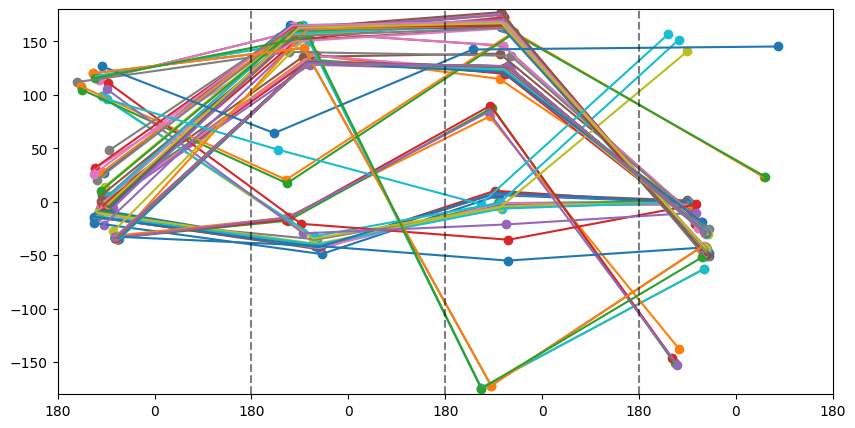

In [158]:
plot(win5)

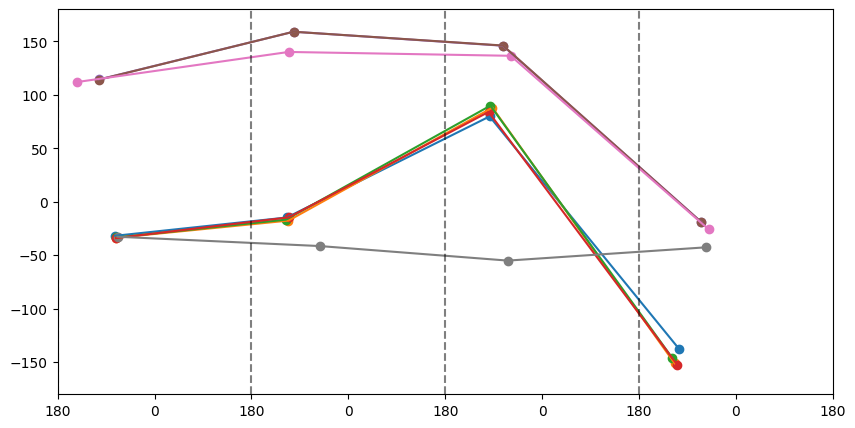

In [155]:
plot(win6)